In [1]:
%cd ../../../

/home/jan/FMF/masters


In [2]:
saved = "ml_hep_sim/notebooks/article_notebooks/saved/"

In [3]:
from ml_hep_sim.notebooks.article_notebooks.test_runs import *
from ml_hep_sim.pipeline.pipes import *
from ml_hep_sim.pipeline.blocks import *

from ml_hep_sim.plotting.style import style_setup, set_size
from ml_hep_sim.stats.stat_plots import two_sample_plot

from ml_hep_sim.data_utils.higgs.process_higgs_dataset import LATEX_COLNAMES, LOG_BIN_RANGES

from matplotlib.patches import Rectangle
import matplotlib 
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy

set_size()
style_setup(seaborn_pallete=True)

In [4]:
glow_train = run_glow_pipeline(
        False,
        False,
        False,
        sig=False,
        num_flows=[10],
        num_train=np.logspace(4, 6, 10).astype(int),
    )

maf_train = run_maf_pipeline(
        False,
        False,
        False,
        sig=False,
        use_mog=True,
        use_maf=True,
        num_mogs=[10],
        num_train=np.logspace(4, 6, 10).astype(int),
    )

spline_train = run_spline_pipeline(
        False,
        False,
        False,
        sig=False,
        num_splines=[32],
        name_str="",
        num_train=np.logspace(4, 6, 10).astype(int),
    )

pipelines = [glow_train[-2], maf_train[-1], spline_train[-1]]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 12111.76it/s]


In [5]:
# glow_pipeline = run_glow_pipeline(train=False, gen=False, test=False)[3][0]
# mafmademog_pipeline = run_maf_pipeline(train=False, gen=False, test=False, use_mog=True, use_maf=True, num_mogs=[10], name_str="_rerun_10_2")[0]
# spline_pipeline = run_spline_pipeline(train=False, gen=False, test=False, num_splines=[12])[0]

# pipelines = [glow_pipeline, mafmademog_pipeline, spline_pipeline]

In [6]:
N = 2 * 10**6
device = "cuda"

res = []

for pipeline in pipelines:

    x_ConfigBuilderBlock, _, _, x_ModelTrainerBlock = pipeline.pipes
    x_ConfigBuilderBlock.config["datasets"]["data_params"]["subset_n"] = [250000, 100000, N]

    x1 = ModelLoaderBlock(device=device)(x_ConfigBuilderBlock, x_ModelTrainerBlock)

    x2 = DataGeneratorBlock(N, model_type="flow", chunks=100, device=device)(x1)
    x3 = GeneratedDataVerifierBlock(save_data=False, device=device, rescale_data=True)(x1, x2)

    x4 = DatasetBuilderBlock()(x_ConfigBuilderBlock)
    x5 = ReferenceDataLoaderBlock(rescale_reference=None, device="cpu")(x4)
    
    pipe = Pipeline()
    pipe.compose(x1, x2, x3, x4, x5)
    pipe.fit()
    
    res.append(pipe.pipes[2].generated_data.cpu().numpy())
    
ref = x5.reference_data.cpu().numpy()

res.append(ref)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.15it/s]
/home/jan/FMF/masters/ml_hep_sim/data_utils/dataset_utils.py:59: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:13<00:00,  1.94s/it]


In [7]:
def N_sample_plot(
    samples,
    axs,
    n_bins="auto",
    label=None,
    labels=None,
    log_scale=False,
    bin_range=None,
    xlim=None,
    titles=None,
    last_c="C7",
    add_mc_err=True,
    **kwargs,
):
    n_features = samples[0].shape[1]

    if bin_range is not None:
        if not any(isinstance(el, list) for el in bin_range):
            bin_range = [bin_range] * n_features

    combined_sample = np.concatenate(samples)

    for feature in range(n_features):
        bin_edges = np.histogram_bin_edges(
            combined_sample[:, feature], bins=n_bins, range=bin_range[feature] if bin_range else None
        )
        
        if feature == 0:
            axs[feature].set_ylabel("$N$")

        for i, sample in enumerate(samples):
            if i == len(samples) - 1:
                n, b, _ = axs[feature].hist(sample[:, feature], bins=bin_edges, histtype="stepfilled", color=last_c, lw=2, alpha=0.5)
            else:
                n, b, _ = axs[feature].hist(sample[:, feature], bins=bin_edges, histtype="step", **kwargs)

        if feature == 0 and label is not None:
            axs[feature].legend(label, fontsize=14)

        if labels is not None:
            axs[feature].set_xlabel(labels[feature], size=20)

        if log_scale:
            axs[feature].set_yscale("log")

        if xlim:
            axs[feature].set_xlim(xlim[feature])

        if titles is not None:
            axs[feature].set_title(titles[feature], size=15, loc="right")
        
        if add_mc_err:
            for ni, b_left, b_right in zip(n, b, b[1:]):
                n_ = np.sqrt(N)
                axs[feature].add_patch(Rectangle((b_left, ni - n_), b_right - b_left, n_, zorder=0, alpha=0.5))

    return axs

In [8]:
LOG_BIN_RANGES = [
    [-1, 15],
    [-3, 3],
    [-1, 15],
    [-1, 12],
    [-4, 4],
    [-1, 14],
    [-5, 5],
    [-1, 14],
    [-4, 4],
    [-1, 15],
    [-4, 4],
    [-1.5, 30],
    [-1, 15],
    [-1, 10],
    [-1, 15],
    [-1, 15],
    [-1, 11],
    [-1, 8],
]

BIN_RANGES = [
    [0, 4],
    [-3, 3],
    [-0.1, 4],
    [0, 5],
    [-4, 4],
    [0, 4],
    [-5, 5],
    [0, 5],
    [-4, 4],
    [0, 5],
    [-3, 3],
    [0, 3],
    [0, 3],
    [0.75, 1.5],
    [0, 3],
    [0, 3],
    [0, 3],
    [0, 3],
]

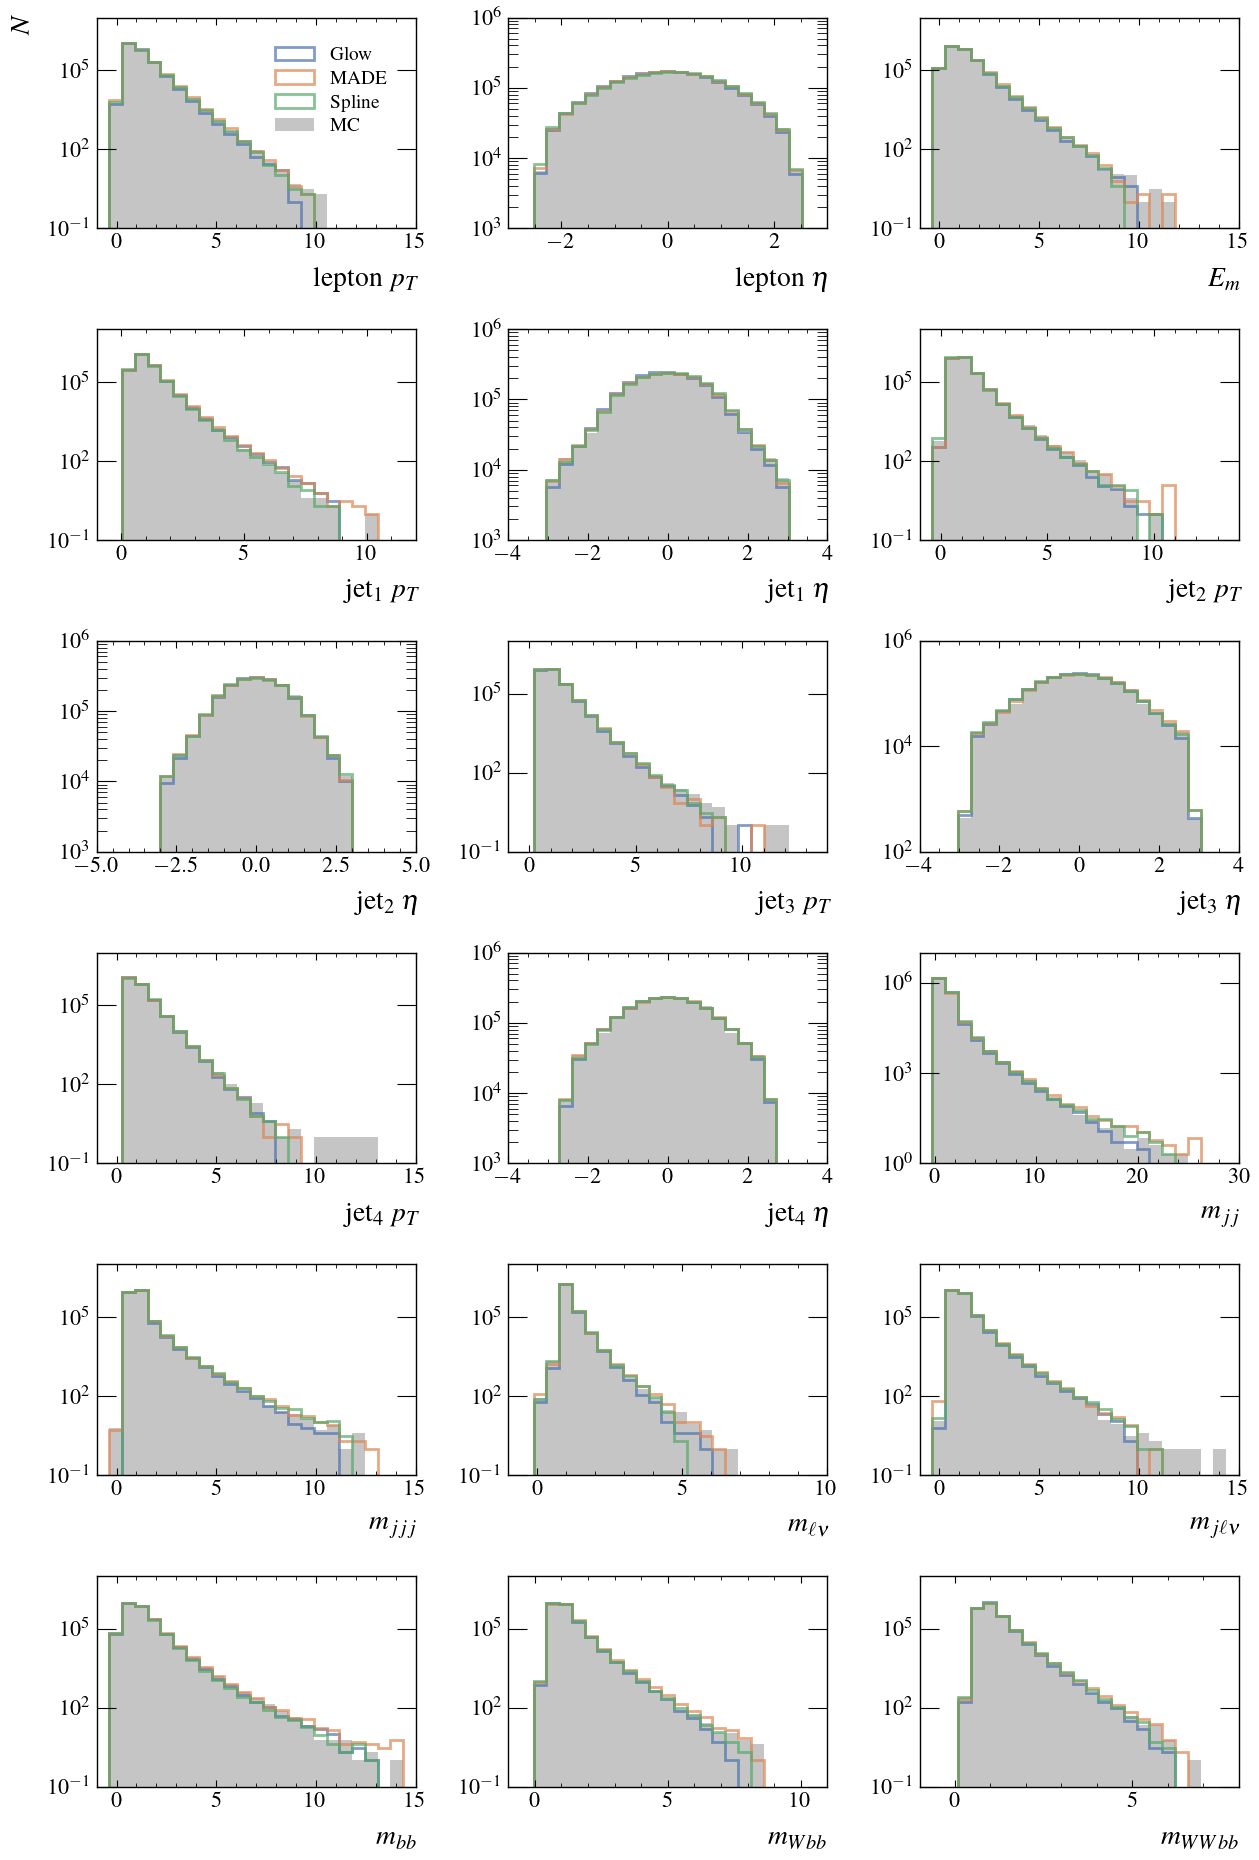

In [9]:
fig, axs = plt.subplots(6, 3, figsize=(13, 19))
axs = axs.flatten()

N_sample_plot(res, axs, n_bins=25, log_scale=True, 
              labels=LATEX_COLNAMES, lw=2, alpha=0.7, 
              label=["Glow", "MADE", "Spline", "MC"],
              xlim=LOG_BIN_RANGES, bin_range=LOG_BIN_RANGES, add_mc_err=False)
plt.tight_layout()
plt.savefig("mc_gen_dists_log.pdf")

  0%|                                                                                                                                                                         | 0/18 [00:00<?, ?it/s]/tmp/ipykernel_174412/4072474604.py:20: RuntimeWarning: invalid value encountered in true_divide
  axs[i].scatter(l, hist_a / hist_mc, s=25)
/tmp/ipykernel_174412/4072474604.py:21: RuntimeWarning: divide by zero encountered in true_divide
  axs[i].scatter(l, hist_b / hist_mc, s=25)
/tmp/ipykernel_174412/4072474604.py:22: RuntimeWarning: divide by zero encountered in true_divide
  axs[i].scatter(l, hist_c / hist_mc, s=25)
 17%|██████████████████████████▊                                                                                                                                      | 3/18 [00:01<00:06,  2.20it/s]/tmp/ipykernel_174412/4072474604.py:20: RuntimeWarning: divide by zero encountered in true_divide
  axs[i].scatter(l, hist_a / hist_mc, s=25)
/tmp/ipykernel_174412/4072474604.py:20:

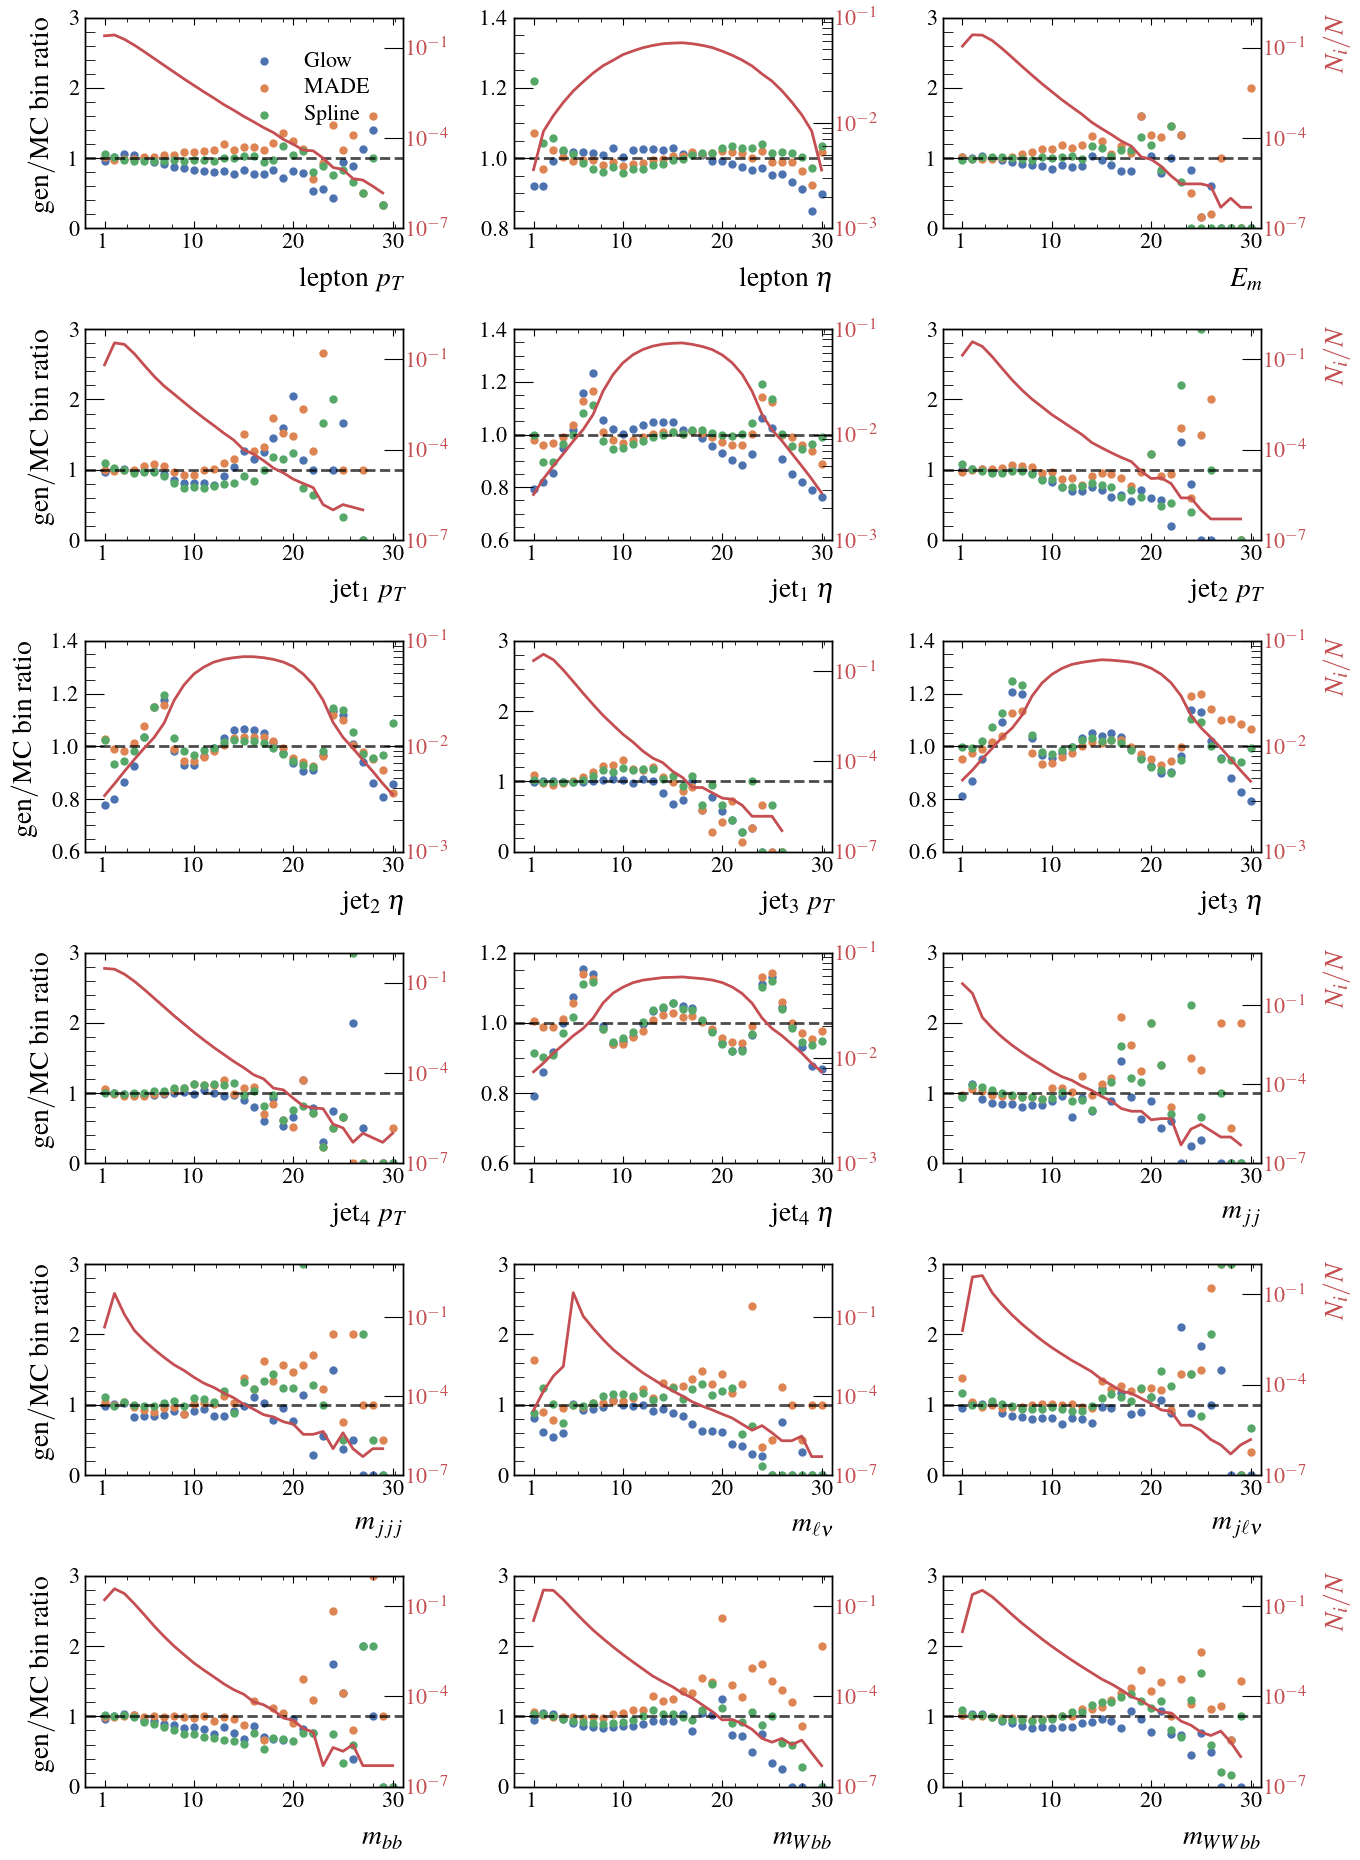

In [10]:
fig, axs = plt.subplots(6, 3, figsize=(14, 19))
axs = axs.flatten()

n_bins = 30

a, b, c, mc = res

combined_sample = np.concatenate([a, b, c])
        
for i in tqdm(range(18)):
    bin_edges = np.histogram_bin_edges(combined_sample[:, i], bins=n_bins)
    
    hist_a, _ = np.histogram(a[:, i], bins=bin_edges)
    hist_b, _ = np.histogram(b[:, i], bins=bin_edges)
    hist_c, _ = np.histogram(c[:, i], bins=bin_edges)
    hist_mc, _ = np.histogram(mc[:, i], bins=bin_edges)
    
    l = np.array(range(len(hist_a))) + 1
    
    axs[i].scatter(l, hist_a / hist_mc, s=25)
    axs[i].scatter(l, hist_b / hist_mc, s=25)
    axs[i].scatter(l, hist_c / hist_mc, s=25)
    
    axs[i].set_xlim(-1, n_bins + 1)
    axs[i].set_xlabel(LATEX_COLNAMES[i])
    
    if i not in [1, 4, 6, 8, 10]:
        axs[i].set_ylim([0, 3])
    
    if i in [0, 3, 6, 9, 12, 15]:
        axs[i].set_ylabel("gen$/$MC bin ratio")
    
    if i == 0:
        axs[i].legend(["Glow", "MADE", "Spline"], loc="upper right")
    
    axs[i].axhline(1, c="k", ls='--', alpha=0.7)
    
    axs[i].set_xticks([1, 10, 20, 30])
    axs[i].set_xticklabels([1, 10, 20, 30])
    
    ax2 = axs[i].twinx()
    
    r = hist_mc / np.sum(hist_mc)
    idx = np.where(r != 0)[0]
    
    cl = "C3"
    ax2.plot(l[idx], r[idx], c=cl, lw=2, ls="-")
    ax2.tick_params(axis="y", labelcolor=cl)
    ax2.set_yscale("log")
    
    if i in [2, 5, 8, 11, 14, 17]:
        ax2.set_ylabel("$N_i/N$", c=cl)
    
plt.tight_layout()
# plt.savefig(saved + "ratios.pdf")